# Physics-Informed Neural Network (PINN) in Julia

This is a simple showcase of how PINNs can learn the solution to (Partial) Differential Equations without labelled data by leveraging automatic differentation to train on a residuum loss of the boundary value problem.

We will consider the 1D Poisson equation
$$
\begin{cases}
\frac{\partial^2 u}{\partial x^2} &= - f(x), \qquad & x \in \Omega = (0, 1)
\\
u(0) &= 0 = u(1)
\end{cases}
$$

For $f(x) = \sin(\pi x)$, the analytical solution is $\hat{u}(x) = \frac{1}{\pi^2} \sin(\pi x)$. We aim to train a shallow neural network to learn the mapping $x \mapsto u$.

This can be done by chosing collocation points, i.e., random points within the domain at which we enfore the PDE. A difference of the neural network against this underlying description will constitute to the loss. Additionally, we will also penalize if the network does not obey the homogeneous Dirichlet boundary conditions. As such our loss is

$$
\mathcal{L} = \alpha_{int} \frac{1}{2N} \sum_{i=1}^N \left( \frac{\partial^2 u}{\partial x^2}\bigg|_{x_i} + f(x_i)  \right)^2  + \alpha_{bc} \frac{1}{2 \cdot 2} \left( u(0)^2 + u(1)^2 \right)
$$

with hyperparameters to weigh the two components of the loss. Our neural network is parameterized by its weights and biases. We can backprop from this loss into the parameter space to obtain a gradient estimate which guides a gradient-based optimizer (here we will use ADAM).

**Julia's reverse-mode automatic differentiation ecosystem, as of now, does not properly support higher-order autodiff**. However, this is crucial, because ultimately we need three autodiff passes, two to get the second derivative within the loss formulation and another one to obtain a gradient estimate in the parameter space.

## Employed architecture

This intro follows the work of Lagaris et al. ([https://arxiv.org/abs/physics/9705023](https://arxiv.org/abs/physics/9705023)) that use a neural network with **one hidden layer**. By the universal approximation theorem, this is sufficient to capture (almost) any function. Hence, given the hidden layer is chosen large enough, it should also be possible to approximate the solution to the PDE. The forward pass of the network becomes

$$
u = v^T \sigma.(w x + b)
$$

We assume our network to be a scalar-to-scalar map, hence

$$
x \in \R, w \in \R^h, b \in \R^h, v \in \R^h, u \in \R
$$

with $h$ being the size of the hidden dimension.

### Analytical Input-Output derivative

**Our goal is to reduce to only one application of the Julia reverse-mode autodiff engine; the pullback from loss to parameter space.** As such, we want to find hand-coded derivatives for the network architecture in their input-output relation.

We can derive this simple shallow network to get

$$
\begin{aligned}
\frac{\partial u}{\partial x} &= (v \odot w)^T \sigma'(w x + b)
\\
\frac{\partial^2 u}{\partial x^2} &= (v \odot w.^2)^T \sigma''(w x + b)
\\
\frac{\partial^l u}{\partial x^l} &= (v \odot w.^l)^T \sigma^{(l)}(w x + b)
\end{aligned}
$$

### The batched case

For all practical applications, we want to query our network batched, i.e., for multiple inputs at the same time. Following the Julia convention, we will therefore the denote the collection of inputs as $x \in \R^{1 \times N}$ and the collection of outputs as $u \in \R^{1 \times N}$. As such, the forward pass becomes

$$
u = V \cdot \sigma.(W \cdot x .+ b)
$$

with the sizes

$$
x \in \R^{1 \times N}, W \in \R^{h, 1}, b \in \R^h, V \in \R^{1, h}, u \in \R^{1 \times N}
$$

### Properties of the sigmoid

Its higher derivatives can be expressed using the primal output

$$
\begin{aligned}
\sigma(x) &= \frac{1}{1 + e^{-x}}
\\
\sigma' &= \sigma (1 - \sigma)
\\
\sigma'' &= \sigma (1 - \sigma) \left( 1- 2\sigma \right) = \sigma' \left( 1- 2\sigma \right)
\end{aligned}
$$



In [158]:
using Optimisers, Zygote, Plots, Random, Distributions
using FiniteDiff

In [159]:
using ReverseDiff

In [160]:
SEED = 42
N_collocation_points = 50
HIDDEN_DEPTH = 100
LEARNING_RATE = 1e-3
N_EPOCHS = 20_000
BC_LOSS_WEIGHT = 100.0

100.0

In [161]:
rhs_function(x) = sin(π * x)
analytical_solution(x) = sin(π * x) / π^2

analytical_solution (generic function with 1 method)

In [162]:
rng = MersenneTwister(SEED)

MersenneTwister(42)

In [163]:
sigmoid(x) = 1.0 / (1.0 + exp(-x))

sigmoid (generic function with 1 method)

In [164]:
# Initialize the weights according to the Xavier Glorot initializer
uniform_limit = sqrt(6 / (1 + HIDDEN_DEPTH))
W = rand(
    rng,
    Uniform(-uniform_limit, +uniform_limit),
    HIDDEN_DEPTH,
    1,
)
V = rand(
    rng,
    Uniform(-uniform_limit, +uniform_limit),
    1,
    HIDDEN_DEPTH,
)
b = zeros(HIDDEN_DEPTH)

100-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [165]:
parameters = (; W, V, b)

(W = [0.10276961030370574; -0.21229892796353997; … ; 0.10161926776805669; 0.04541946666780078;;], V = [-0.1777197430255085 -0.17909130185688604 … 0.057382630868962226 -0.05530028611229676], b = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [166]:
network_forward(x, p) = p.V * sigmoid.(p.W * x .+ p.b)

network_forward (generic function with 1 method)

In [167]:
x_line = reshape(collect(range(0.0f0, stop=1.0f0, length=100)), (1, 100))

1×100 Matrix{Float32}:
 0.0  0.010101  0.020202  0.030303  …  0.969697  0.979798  0.989899  1.0

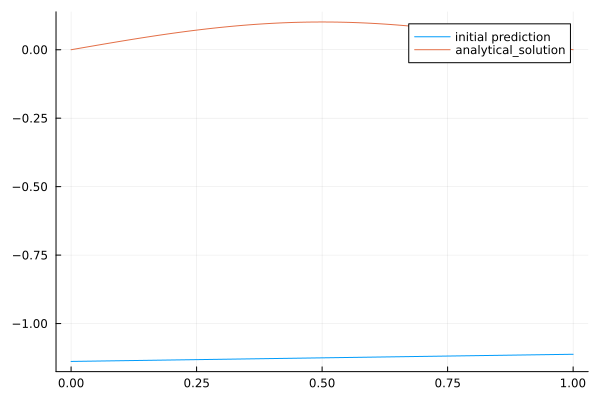

In [168]:
# Plot initial prediction of the network (together with the analytical solution)
plot(x_line[:], network_forward(x_line, parameters)[:], label="initial prediction")
plot!(x_line[:], analytical_solution.(x_line[:]), label="analytical_solution")

In [169]:
ε3

0.000740095979741405

In [170]:
function network_forward_wrapper(x)
    return network_forward(x, parameters)[1]
end

function network_output_and_first_two_derivatives(x, p)
    f(x)=(p.V * sigmoid.(p.W * x .+ p.b))[1]
    activated_state = sigmoid.(p.W * x .+ p.b)
    sigmoid_prime = activated_state .* (1.0 .- activated_state)
    sigmoid_double_prime = sigmoid_prime .* (1.0 .- 2.0 .* activated_state)

    output = p.V * activated_state
    first_derivative = (f.(x_line .+ ε) - f.(x_line .- ε)) / (2 * ε)#(p.V .* p.W') * sigmoid_prime
    #first_derivative = TaylorDiff.derivative.(f, x, Val(1))
    second_derivative = (network_forward_wrapper.(x .+ ε2) .- 2 .* network_forward_wrapper.(x) .+ network_forward_wrapper.(x .- ε2)) / (ε2^2)#(p.V .* p.W' .* p.W') * sigmoid_double_prime#(f.(x_line .+ ε2) .- 2 .* f.(x_line) .+ f.(x_line .- ε2)) / (ε2^2)#(p.V .* p.W' .* p.W') * sigmoid_double_prime
    #second_derivative = TaylorDiff.derivative.(f, x, Val(2))
    #second_derivative = Float64.(Zygote.gradient(x -> sum(f(x)), x)[1])

    return output, first_derivative, second_derivative
end

network_output_and_first_two_derivatives (generic function with 1 method)

In [171]:
_output, _first_derivative, _second_derivative = network_output_and_first_two_derivatives(x_line, parameters)
_second_derivative

1×100 Matrix{Float64}:
 5.96046e-8  -2.77162e-6  -5.51343e-6  …  -0.000271767  -0.000274673

In [172]:
using TaylorDiff
function f(x)
    return network_forward(x, parameters)[1]
end

_TaylorDiff_first_derivative = TaylorDiff.derivative.(f, x_line, Val(2))
 

1×100 Matrix{Float64}:
 0.0  -2.80508e-6  -5.61013e-6  -8.41515e-6  …  -0.000271856  -0.000274567

In [173]:
network_forward_wrapper.(x_line)

1×100 Matrix{Float64}:
 -1.13829  -1.13803  -1.13776  -1.1375  …  -1.11266  -1.1124  -1.11213

In [174]:
# Obtener el valor de εmachine para Float64
εmachine = eps(Float64)

# Definir los valores de ε
ε1 = εmachine^(1/3)
ε2 = εmachine^(1/4)
ε3 = εmachine^(1/5)

# Definir la línea de puntos x_line
x_line = reshape(collect(range(0.0f0, stop=1.0f0, length=100)), (1, 100))

# Calcular la primera derivada numérica usando diferencias finitas centradas con ε1
∂u_∂x_ε1 = (f.(x_line .+ ε1) .- f.(x_line .- ε1)) / (2 * ε1)

# Calcular la segunda derivada numérica usando diferencias finitas centradas con ε2
∂²u_∂x²_ε2 = (f.(x_line .+ ε2) .- 2 .* f.(x_line) .+ f.(x_line .- ε2)) / (ε2^2)

# Mostrar los resultados
println("Primera derivada numérica de f(x) con respecto a x en x_line (ε1): ", ∂u_∂x_ε1)
println("Segunda derivada numérica de f(x) con respecto a x en x_line (ε2): ", ∂²u_∂x²_ε2)



Primera derivada numérica de f(x) con respecto a x en x_line (ε1): [0.02620640588992534 0.02620639182754461 0.02620634916371156 0.026206278448454103 0.026206179388424025 0.02620605170860735 0.026205895959032017 0.026205711773012733 0.026205499352226408 0.026205258439993342 0.0262049893113275 0.026204691764551973 0.026204366111349253 0.026204011911697 0.026203629532280497 0.02620321880809137 0.02620277975746388 0.02620231236206376 0.02620181669522807 0.026201292720288285 0.026200740437244397 0.026200159901099206 0.02619955098351286 0.02619891373948815 0.026198248370701983 0.02619755469381172 0.026196832727151623 0.026196082562393013 0.026195303961190453 0.02619449723522644 0.02619366218282406 0.026192799042328758 0.026191907502058034 0.026190987763688795 0.026190039827221047 0.026189063619317728 0.02618805919498163 0.026187026554212758 0.02618596582535096 0.026184876898390646 0.026183759699994764 0.026182614211829047 0.026181440855581575 0.026180239154561476 0.0261790092371086 0.0261777

In [175]:
interior_collocation_points = rand(rng, Uniform(0.0, 1.0), (1, N_collocation_points))

1×50 Matrix{Float64}:
 0.0357248  0.473918  0.441437  0.841032  …  0.872303  0.680714  0.776496

In [176]:
boundary_collocation_points = [0.0 1.0]

1×2 Matrix{Float64}:
 0.0  1.0

In [177]:
function loss_forward(p)
    output, first_derivative, second_derivative = network_output_and_first_two_derivatives(
        interior_collocation_points,
        p,
    )

    interior_residuals = second_derivative .+ rhs_function.(interior_collocation_points)

    interior_loss = 0.5 * mean(interior_residuals.^2)

    boundary_residuals = network_forward(boundary_collocation_points, p) .- 0.0

    boundary_loss = 0.5 * mean(boundary_residuals.^2)

    total_loss = interior_loss + BC_LOSS_WEIGHT * boundary_loss

    return total_loss
end

loss_forward (generic function with 1 method)

In [178]:
opt = Adam(LEARNING_RATE)

Adam(0.001, (0.9, 0.999), 1.0e-8)

In [179]:
opt_state = Optimisers.setup(opt, parameters)
loss_history = []
for i in 1:N_EPOCHS
    loss, back = Zygote.pullback(loss_forward, parameters)
    push!(loss_history, loss)
    grad, = back(1.0)
    opt_state, parameters = Optimisers.update(opt_state, parameters, grad)
    if i % 100 == 0
        println("Epoch: $i, Loss: $loss")
    end
end

Epoch: 100, Loss: 0.31273426047284636
Epoch: 200, Loss: 0.2670059136352804
Epoch: 300, Loss: 0.25305637037452566
Epoch: 400, Loss: 0.25044881471129404
Epoch: 500, Loss: 0.2501555671000619
Epoch: 600, Loss: 0.25014036082152413
Epoch: 700, Loss: 0.2501416606037805
Epoch: 800, Loss: 0.25014212236790145
Epoch: 900, Loss: 0.2501422027290245
Epoch: 1000, Loss: 0.2501422114616156
Epoch: 1100, Loss: 0.25014220429211836
Epoch: 1200, Loss: 0.2501422123504883
Epoch: 1300, Loss: 0.25014221037831014
Epoch: 1400, Loss: 0.25014220817798055
Epoch: 1500, Loss: 0.2501422099193303
Epoch: 1600, Loss: 0.25014221008943854
Epoch: 1700, Loss: 0.25014221006958837
Epoch: 1800, Loss: 0.25014221099262524
Epoch: 1900, Loss: 0.2501422088416392
Epoch: 2000, Loss: 0.25014220767328
Epoch: 2100, Loss: 0.2501422088632645
Epoch: 2200, Loss: 0.25014220867439785
Epoch: 2300, Loss: 0.25014220815931737
Epoch: 2400, Loss: 0.25014220919950275
Epoch: 2500, Loss: 0.25014220850379715
Epoch: 2600, Loss: 0.2501422089404721
Epoch: 2

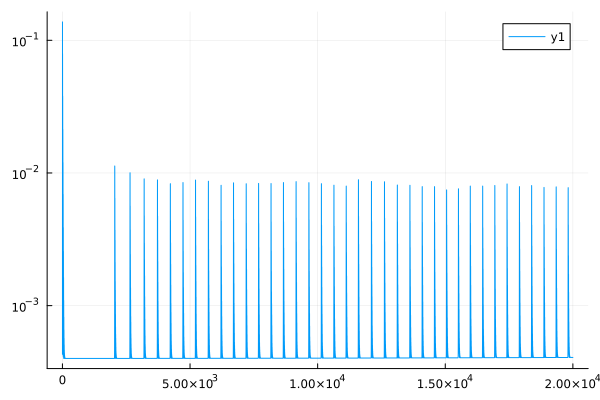

In [122]:
plot(loss_history, yscale=:log10)

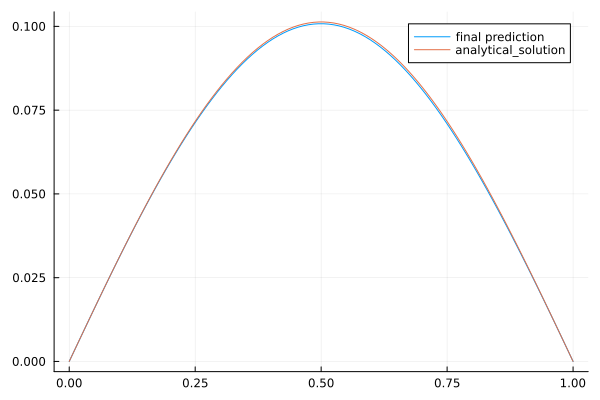

In [123]:
plot(x_line[:], network_forward(x_line, parameters)[:], label="final prediction")
plot!(x_line[:], analytical_solution.(x_line[:]), label="analytical_solution")